In [1]:
import pandas as pd
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from typing import Optional, Callable

# --- データ読み込み用関数 (変更なし) ---

def get_behaiver_map(filepath: str) -> dict:
    """
    指定されたパスのファイルを読み込み、行動名とIDの辞書を生成する。
    """
    behavior_to_id = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            parts = line.rsplit(maxsplit=1)
            if len(parts) == 2:
                name = parts[0].strip()
                id_val = int(parts[1])
                behavior_to_id[name] = id_val
    return behavior_to_id

def create_dataframe_manually_robust(filepath: str) -> pd.DataFrame:
    """
    ファイルを1行ずつ手動で読み込み、DataFrameを構築する。
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        header_line = f.readline()
        if not header_line:
            return pd.DataFrame() 
        
        columns = re.split(r'\s+', header_line.strip())
        num_columns = len(columns)
        data_rows = []
        
        for line_num, line in enumerate(f, 2):
            line_stripped = line.strip()
            if not line_stripped:
                continue
            
            row_data = re.split(r'\s+', line_stripped)
            
            if len(row_data) == num_columns:
                data_rows.append(row_data)
            elif len(row_data) > num_columns:
                order = row_data[-1]
                family = row_data[-2]
                genus = ' '.join(row_data[:-2])
                reconstructed_row = [genus, family, order]
                data_rows.append(reconstructed_row)
            else:
                print(f"警告: 行 {line_num}: 列数が期待値 ({num_columns}) 未満のためスキップ。内容: '{line_stripped}'", file=sys.stderr)
        
        df = pd.DataFrame(data_rows, columns=columns)
        return df

# --- フレーム抽出ロジック (変更なし) ---

def find_max_diff_frame_index(video_path: str) -> int:
    """
    動画を読み込み、フレーム間差分が最大のフレーム番号（インデックス）を返す。
    差分は (current - prev) で計算し、current_frame のインデックスを返す。
    エラー時は -1 を返す。
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"エラー: 動画ファイル {video_path} を開けません。", file=sys.stderr)
        return -1

    max_diff = -1.0
    max_diff_frame_index = 0
    current_frame_index = 0

    ret, prev_frame = cap.read()
    if not ret:
        print(f"エラー: {video_path} からフレームを読み込めません。", file=sys.stderr)
        cap.release()
        return -1

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    while True:
        current_frame_index += 1
        ret, current_frame = cap.read()
        if not ret:
            break

        current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        frame_diff = cv2.absdiff(prev_gray, current_gray)
        current_diff = np.sum(frame_diff) 

        if current_diff > max_diff:
            max_diff = current_diff
            max_diff_frame_index = current_frame_index

        prev_gray = current_gray

    cap.release()
    return max_diff_frame_index

def get_frame_by_index(video_path: str, frame_index: int) -> Optional[np.ndarray]:
    """
    動画の指定されたフレーム番号のフレーム画像 (BGR) を取得する。
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"エラー: 動画ファイル {video_path} を開けません。", file=sys.stderr)
        return None
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"エラー: {video_path} のフレーム {frame_index} を読み込めません。", file=sys.stderr)
        return None
        
    return frame

# --- 可視化関数 (修正) ---

def create_action_scrapbook(
    df: pd.DataFrame,
    action_col: str,
    video_path_col: str,
    genus_col: str,
    base_dir: str,
    frame_extractor_func: Callable[[str], int],
    n_samples: int = 5
):
    """
    行動ラベルごと、Nサンプルの動画スクラップブックを生成し、plt.show()で表示する。
    各画像のタイトルに行動名、Genus、フレーム番号を表示する。
    """
    
    unique_actions = sorted(df[action_col].unique())
    n_rows = len(unique_actions)
    n_cols = n_samples

    if n_rows == 0:
        print("表示対象のデータがありません。", file=sys.stderr)
        return

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3.5), squeeze=False)
    
    plt.rcParams.update({'font.size': 8})

    for row_idx, action_name in enumerate(unique_actions):
        
        # --- 修正点 ---
        # Y軸ラベルの表示を削除
        # axes[row_idx, 0].set_ylabel(action_name, fontsize=12, rotation=90, labelpad=30)
        
        action_df = df[df[action_col] == action_name]
        
        n_available = len(action_df)
        samples = action_df.sample(n=min(n_available, n_samples), random_state=42)

        for col_idx in range(n_cols):
            ax = axes[row_idx, col_idx]
            ax.axis('off') 

            if col_idx < len(samples):
                sample_row = samples.iloc[col_idx]
                
                video_path_relative = sample_row[video_path_col]
                full_video_path = os.path.join(base_dir, video_path_relative)
                genus = sample_row[genus_col]
                
                frame_idx = frame_extractor_func(full_video_path)
                
                frame_img = None
                if frame_idx >= 0:
                    frame_img = get_frame_by_index(full_video_path, frame_idx)
                
                if frame_img is not None:
                    frame_rgb = cv2.cvtColor(frame_img, cv2.COLOR_BGR2RGB)
                    ax.imshow(frame_rgb)
                    # --- 修正点 ---
                    # タイトルに行動名、Genus、フレーム番号を表示
                    ax.set_title(f"Action: {action_name}\nGenus: {genus}\nFrame: {frame_idx}", fontsize=9)
                else:
                    ax.text(0.5, 0.5, 'Img Load Error', ha='center', va='center', color='red', fontsize=9)
            else:
                ax.text(0.5, 0.5, 'N/A', ha='center', va='center', color='gray', fontsize=9)

    fig.suptitle(f"Action Scrapbook (Samples per Action: {n_samples})", fontsize=16, y=1.02)
    
    # --- 修正点 ---
    # レイアウト調整を fig.subplots_adjust から tight_layout に戻す
    # (Y軸ラベルが不要になったため、左マージンは不要)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    plt.show()


--- スクラップブック生成中 ---


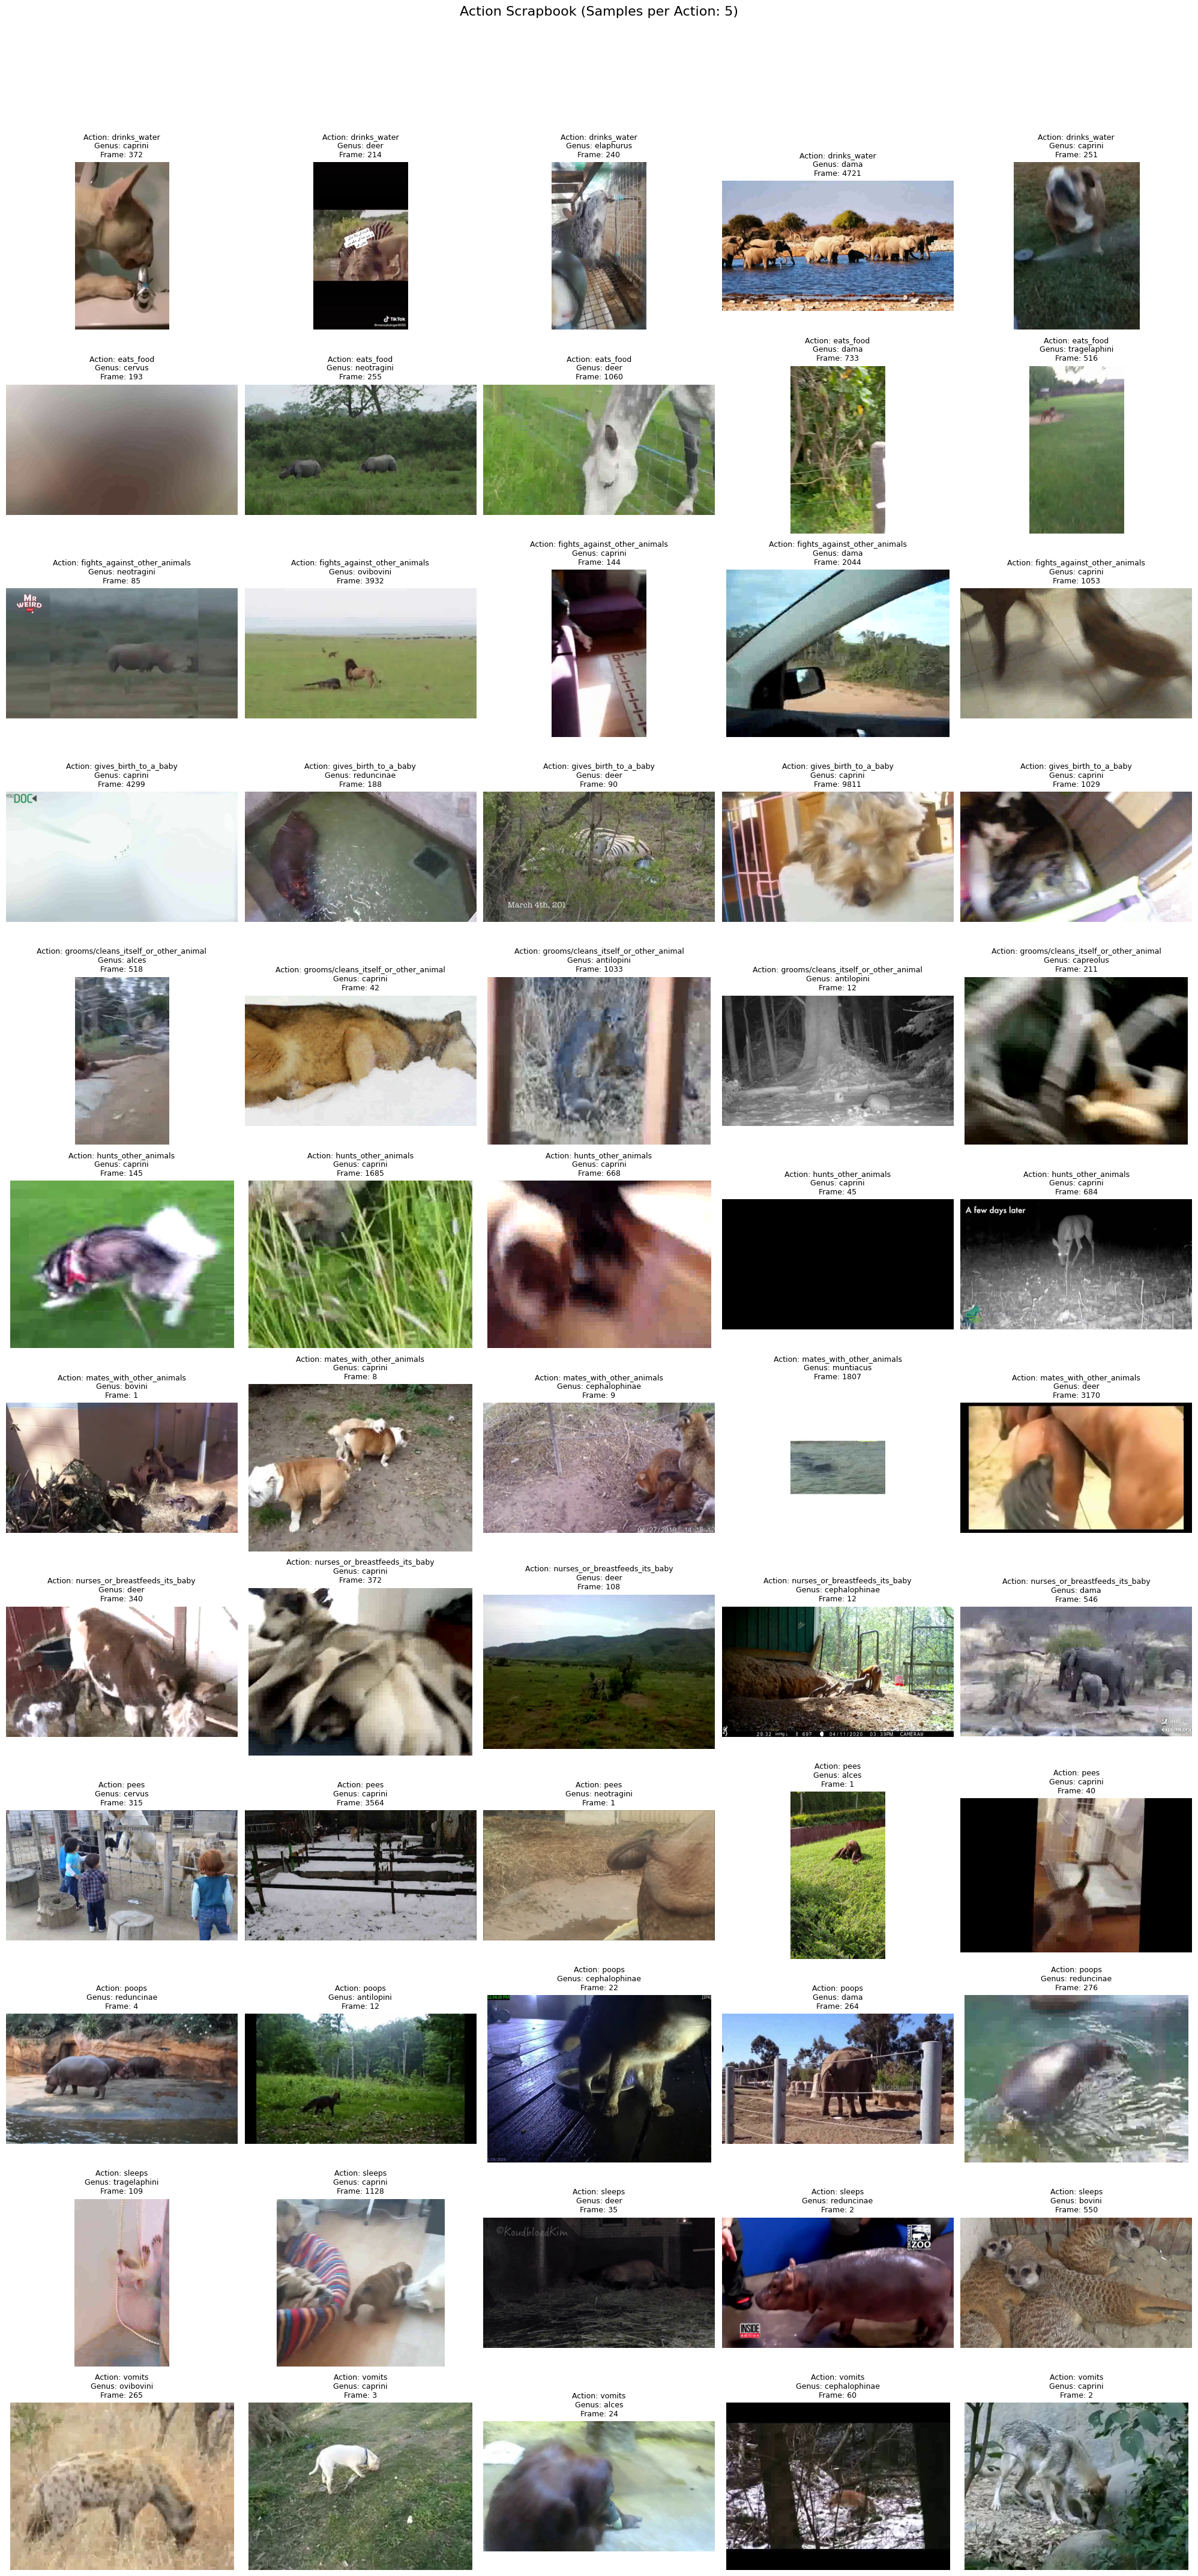

----------------------------


In [2]:
# --- 1. データ読み込みと前処理 (変更なし) ---

# ファイルパス定義
data_base_dir = '/mnt/nfs/mammal_net/' # 動画パスのプレフィックスとしても使用
train_csv_path = os.path.join(data_base_dir, 'annotation/composition/train.csv')
behavior_map_path = os.path.join(data_base_dir, 'annotation/behavior_to_id.txt')
taxonomy_path = os.path.join(data_base_dir, 'annotation/taxonomy.txt')

# train_df
train_df = pd.read_csv(train_csv_path, header=None, names=['video_path', 'action_label', 'mammal_category'], sep=' ')

# behavior_dict
inv_behavior_dict = get_behaiver_map(behavior_map_path)
behavior_dict = {v: k for k, v in inv_behavior_dict.items()}

# mammal_category_df
mammal_category_df = create_dataframe_manually_robust(taxonomy_path)
mammal_category_df = mammal_category_df.reset_index()
mammal_category_df = mammal_category_df.rename(columns={'index': 'mammal_category'})

# マージ
train_df['action_label_name'] = train_df['action_label'].map(behavior_dict)
train_df = train_df.merge(on='mammal_category', right=mammal_category_df, how='left', suffixes=('', '_y'))

# フィルタリング
target_orders = ['aerissodactyla', 'artiodactyla']
target_families = ['bovidae', 'cervidae']
train_df = train_df.loc[train_df['Order'].isin(target_orders)]
train_df = train_df.loc[train_df['Family'].isin(target_families)]

# --- 2. スクラップブックの実行 (リファクタリング版) ---

# 使用するフレーム抽出関数を定義
# (将来的に find_max_motion_frame_index など別の関数に差し替え可能)
TARGET_FRAME_EXTRACTOR = find_max_diff_frame_index

# スクラップブックを作成・表示
# (フィルタリング後の train_df を渡す)
print("\n--- スクラップブック生成中 ---")
create_action_scrapbook(
    df=train_df,
    action_col='action_label_name',
    video_path_col='video_path',
    genus_col='Genus',
    base_dir=data_base_dir,
    frame_extractor_func=TARGET_FRAME_EXTRACTOR,
    n_samples=5 # 横に表示するサンプル数 (変更可能)
)
print("----------------------------")